<a href="https://colab.research.google.com/github/st0203/Data-Bootcamp-Final-Personalized-Diet-Recommendation-System/blob/main/Predictive_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_path = '/content/sample_data/Personalized_Diet_Recommendations.csv'
diet = pd.read_csv(data_path)

In [ ]:
#Remove duplicates
diet = diet.drop_duplicates()
diet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Patient_ID                5000 non-null   object 
 1   Age                       5000 non-null   int64  
 2   Gender                    5000 non-null   object 
 3   Height_cm                 5000 non-null   int64  
 4   Weight_kg                 5000 non-null   int64  
 5   BMI                       5000 non-null   float64
 6   Chronic_Disease           2957 non-null   object 
 7   Blood_Pressure_Systolic   5000 non-null   int64  
 8   Blood_Pressure_Diastolic  5000 non-null   int64  
 9   Cholesterol_Level         5000 non-null   int64  
 10  Blood_Sugar_Level         5000 non-null   int64  
 11  Genetic_Risk_Factor       5000 non-null   object 
 12  Allergies                 1503 non-null   object 
 13  Daily_Steps               5000 non-null   int64  
 14  Exercise

In [ ]:
#fill null values
diet['Allergies'].fillna('None', inplace=True)
diet['Chronic_Disease'].fillna("None", inplace=True)
diet['Food_Aversions'].fillna("None", inplace=True)

<ipython-input-54-6c92939ba10e>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diet['Allergies'].fillna('None', inplace=True)
<ipython-input-54-6c92939ba10e>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [ ]:
#Drop highly correlated columns: Based on our corr map, BMI vs Weight and BMI vs Height were highly correlated
#For our predictive models to be more accurate and stable, I'm removing weight and high columns from the dataset
#Also drop Patient_ID because it's unuseful
diet.drop(['Weight_kg', 'Height_cm', 'Patient_ID'], axis = 1, inplace=True)
diet.head(2)

,Age,Gender,BMI,Chronic_Disease,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Cholesterol_Level,Blood_Sugar_Level,Genetic_Risk_Factor,Allergies,...,Protein_Intake,Carbohydrate_Intake,Fat_Intake,Preferred_Cuisine,Food_Aversions,Recommended_Calories,Recommended_Protein,Recommended_Carbs,Recommended_Fats,Recommended_Meal_Plan
0,56,Other,24.84,None,175,75,219,124,No,None,...,105,179,143,Western,None,2150,108,139,145,High-Protein Diet
1,69,Female,38.99,None,155,72,208,72,No,None,...,69,315,75,Mediterranean,None,1527,74,266,80,Balanced Diet


In [ ]:
#Drop recommendations
diet.drop(['Recommended_Calories', 'Recommended_Protein', "Recommended_Carbs", 'Recommended_Fats'], axis = 1, inplace=True)

In [ ]:
#Eliminate outliers in BMI data
#numerical_cols = diet.select_dtypes(include='number').columns
#for col in numerical_cols:
Q1 = diet['BMI'].quantile(0.25)
Q3 = diet['BMI'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Keep only rows within the IQR range for this column
diet = diet[(diet['BMI'] >= lower_bound) & (diet['BMI'] <= upper_bound)]

In [ ]:
#Separate data into numerical vs categorical
numerical_cols = diet.select_dtypes(include='number').columns
categorical_cols = diet.select_dtypes(include='object').columns.drop('Recommended_Meal_Plan')

In [ ]:
categorical_cols

Index(['Gender', 'Chronic_Disease', 'Genetic_Risk_Factor', 'Allergies',
       'Alcohol_Consumption', 'Smoking_Habit', 'Dietary_Habits',
       'Preferred_Cuisine', 'Food_Aversions'],
      dtype='object')

In [ ]:
numerical_cols

Index(['Age', 'BMI', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic',
       'Cholesterol_Level', 'Blood_Sugar_Level', 'Daily_Steps',
       'Exercise_Frequency', 'Sleep_Hours', 'Caloric_Intake', 'Protein_Intake',
       'Carbohydrate_Intake', 'Fat_Intake'],
      dtype='object')

#Baseline Model


In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.datasets import load_breast_cancer, load_digits, fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

In [ ]:
#Transforming data: OHE categorical features, Standard scale numerical features
ohe = OneHotEncoder(drop='if_binary')
scaler = StandardScaler()
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', scaler)
])
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

transformer = make_column_transformer(
    (numeric_pipeline, numerical_cols),
    (categorical_pipeline, categorical_cols),
    remainder='passthrough')

In [ ]:
X = diet.drop('Recommended_Meal_Plan', axis=1)
y = diet['Recommended_Meal_Plan']
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
dummy_clf = DummyClassifier(strategy="uniform", random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

In [ ]:
#Accuracy score -- makes sense because it is basically randomly predicting 1 out of the 4 categories for Recommended Meal Plans
accuracy

0.229

In [ ]:
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

    Balanced Diet       0.21      0.22      0.21       251
High-Protein Diet       0.24      0.22      0.23       252
    Low-Carb Diet       0.19      0.21      0.20       216
     Low-Fat Diet       0.26      0.26      0.26       281

         accuracy                           0.23      1000
        macro avg       0.23      0.23      0.23      1000
     weighted avg       0.23      0.23      0.23      1000



#Logistic Regression Model

In [ ]:
#For my models, I decide to use a 80/20 train/test split and a random state of 42

In [ ]:
#Transforming data: OHE categorical features, Standard scale numerical features
ohe = OneHotEncoder(drop='if_binary')
scaler = StandardScaler()
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', scaler)
])
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

transformer = make_column_transformer(
    (numeric_pipeline, numerical_cols),
    (categorical_pipeline, categorical_cols),
    remainder='passthrough')

In [ ]:
#Create Train-Test Split
X = diet.drop('Recommended_Meal_Plan', axis=1)
y = diet['Recommended_Meal_Plan']
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
#Create pipeline for Multiple Regression model and fit it on train data
lgr_pipe = Pipeline([('transform', transformer), ('model', LogisticRegression())])
lgr_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'BMI', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic',
       'Cholesterol_Level', 'Blood_Sugar_Level', 'Daily_Steps',
       'Exercise_Frequency', 'Sleep_Hours', 'Caloric_Intake'...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Gender', 'Chronic_Disease', 'Genetic_Risk_Factor', 'Allergies',
       'Alcohol_Consumption', 'Smoking_Habit', 'Dietary_Habits',
       'Preferred_Cuisine', 'Food_Aversions'],
      dtype='object'))])),
                ('model', LogisticRegression())])

In [ ]:
#Evaluating the LGR model on test data
y_pred_test = lgr_pipe.predict(X_test)
accuracy_score(y_test, y_pred)

0.229

In [ ]:
#Evaluating the LGR model on train data
y_pred_train = lgr_pipe.predict(X_train)
accuracy_score(y_train, y_pred_train)

0.30005005005005003

In [ ]:
print(classification_report(y_test, y_pred_test))

                   precision    recall  f1-score   support

    Balanced Diet       0.26      0.28      0.27       251
High-Protein Diet       0.28      0.26      0.27       252
    Low-Carb Diet       0.22      0.17      0.19       216
     Low-Fat Diet       0.28      0.32      0.30       281

         accuracy                           0.27      1000
        macro avg       0.26      0.26      0.26      1000
     weighted avg       0.26      0.27      0.26      1000



In [ ]:
#Checking coefficients
lr = lgr_pipe.named_steps['model']
coefficients = lr.coef_
names = transformer.get_feature_names_out()
pd.DataFrame(coefficients,columns=names)

,pipeline-1__Age,pipeline-1__BMI,pipeline-1__Blood_Pressure_Systolic,pipeline-1__Blood_Pressure_Diastolic,pipeline-1__Cholesterol_Level,pipeline-1__Blood_Sugar_Level,pipeline-1__Daily_Steps,pipeline-1__Exercise_Frequency,pipeline-1__Sleep_Hours,pipeline-1__Caloric_Intake,...,pipeline-2__Dietary_Habits_Vegan,pipeline-2__Dietary_Habits_Vegetarian,pipeline-2__Preferred_Cuisine_Asian,pipeline-2__Preferred_Cuisine_Indian,pipeline-2__Preferred_Cuisine_Mediterranean,pipeline-2__Preferred_Cuisine_Western,pipeline-2__Food_Aversions_None,pipeline-2__Food_Aversions_Salty,pipeline-2__Food_Aversions_Spicy,pipeline-2__Food_Aversions_Sweet
0,-0.012019,0.063384,0.023221,-0.011453,0.005574,0.006768,-0.001818,-0.029533,0.031786,0.028054,...,-0.125227,0.101871,0.095306,0.008826,-0.022330,-0.083938,0.092938,-0.063552,-0.002937,-0.028584
1,-0.024240,-0.062106,0.010958,0.007863,-0.001584,-0.016859,0.030225,-0.000832,-0.007024,-0.026128,...,0.117788,-0.147276,-0.052307,-0.005948,0.023799,0.035814,0.048437,-0.057893,0.030792,-0.019979
2,0.040368,-0.045513,-0.035639,-0.007840,-0.020919,0.000325,-0.034800,-0.002494,-0.027973,0.011650,...,-0.055044,0.027912,0.009759,0.028085,-0.028868,-0.008051,-0.038780,0.014652,-0.003060,0.028114
3,-0.004108,0.044236,0.001460,0.011430,0.016929,0.009766,0.006394,0.032859,0.003211,-0.013576,...,0.062483,0.017494,-0.052758,-0.030963,0.027399,0.056175,-0.102595,0.106793,-0.024795,0.020450


In [ ]:
#Checking Feature importance
r = permutation_importance(lgr_pipe, X_test, y_test, n_repeats = 10, random_state=42, n_jobs=-1)
lgr_feature_importance = pd.DataFrame(r['importances_mean'], index = X_train.columns.tolist())
#Find the top 10 features
lgr_feature_importance.sort_values(by = 0, ascending = False)

,0
Smoking_Habit,0.0067
Alcohol_Consumption,0.0066
Dietary_Habits,0.0030
Allergies,0.0014
Genetic_Risk_Factor,0.0005
Age,-0.0011
Carbohydrate_Intake,-0.0021
Protein_Intake,-0.0023
Cholesterol_Level,-0.0023
Food_Aversions,-0.0026


#KNN Model

In [ ]:
#Transform data
transformer = make_column_transformer(
    (numeric_pipeline, numerical_cols),
    (categorical_pipeline, categorical_cols),
    remainder='passthrough')
#Create train test split and transform data
X = diet.drop('Recommended_Meal_Plan', axis=1)
y = diet['Recommended_Meal_Plan']
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
#Create Pipeline and fit
knn_pipe = Pipeline([('transform', transformer), ('model', KNeighborsClassifier(n_neighbors = 1))])
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'BMI', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic',
       'Cholesterol_Level', 'Blood_Sugar_Level', 'Daily_Steps',
       'Exercise_Frequency', 'Sleep_Hours', 'Caloric_Intake'...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Gender', 'Chronic_Disease', 'Genetic_Risk_Factor', 'Allergies',
       'Alcohol_Consumption', 'Smoking_Habit', 'Dietary_Habits',
       'Preferred_Cuisine', 'Food_Aversions'],
      dtype='object'))])),
                ('model', KNeighborsClassifier(n_neighbors=1))])

In [ ]:
#Accuracy score on test data
y_pred = knn_pipe.predict(X_test)
accuracy_score(y_test, y_pred)

0.281

In [ ]:
#Accuracy score on train data
y_pred = knn_pipe.predict(X_train)
accuracy_score(y_train, y_pred)

1.0

In [ ]:
#Grid search for the best n_neighbors
from sklearn.model_selection import GridSearchCV
params = {'model__n_neighbors': np.arange(1, 30, 2)}
grid = GridSearchCV(estimator=knn_pipe,param_grid=params,scoring='recall')
grid.fit(X,y)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

GridSearchCV(estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'BMI', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic',
       'Cholesterol_Level', 'Blood_Sugar_Level', 'Daily_Steps',
       'Exercise_Frequency', 'Sleep_...
                                                                                                        sparse_output=False))]),
                                                                         Index(['Gender', 'Chronic_Disease', 'Genetic_Risk_Factor', 'Allergies',
       'Alcohol_Consumption', 'Smoking_Habit', 'Dietary_Habits',
       'Preferred_Cuisine', 'Food_Aversions'],
      dtype='object'))])),
                                       ('model',
                                        KNeighborsClassifier(n_neighbors=1))]),
             param_grid={'model__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])},
             scoring='recall')

In [ ]:
grid.best_params_

{'model__n_neighbors': np.int64(1)}

In [ ]:
#the best number of n_neighbors is 1!

In [ ]:
#Looking at best KNN model's accuracy
y_pred = grid.predict(X_test) #Making predictions with the best KNN model found by GridSearchCV
accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred_test))

                   precision    recall  f1-score   support

    Balanced Diet       0.26      0.28      0.27       251
High-Protein Diet       0.28      0.26      0.27       252
    Low-Carb Diet       0.22      0.17      0.19       216
     Low-Fat Diet       0.28      0.32      0.30       281

         accuracy                           0.27      1000
        macro avg       0.26      0.26      0.26      1000
     weighted avg       0.26      0.27      0.26      1000



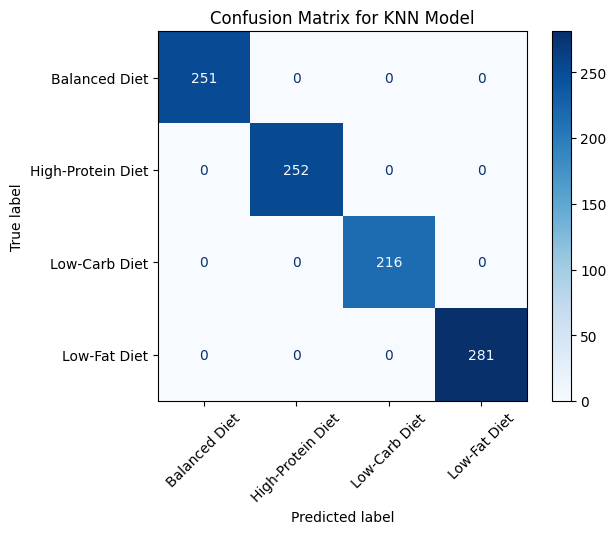

In [ ]:
# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred) #Creating the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_pipe.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for KNN Model")
plt.show()

In [ ]:
#Checking Feature importance
r = permutation_importance(knn_pipe, X_test, y_test, n_repeats = 10)
knn_feature_importance = pd.DataFrame(r['importances_mean'], index = X_train.columns.tolist())
#Find the top 10 features
knn_feature_importance.sort_values(by = 0, ascending = False)

,0
Preferred_Cuisine,0.0168
Sleep_Hours,0.0163
Blood_Sugar_Level,0.0154
Blood_Pressure_Systolic,0.0143
Caloric_Intake,0.0124
Carbohydrate_Intake,0.0123
Gender,0.0110
Food_Aversions,0.0108
Age,0.0090
Blood_Pressure_Diastolic,0.0083


#Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [ ]:
#Transform data
transformer = make_column_transformer(
    (numeric_pipeline, numerical_cols),
    (categorical_pipeline, categorical_cols),
    remainder='passthrough')
#Create train test split and transform data
X = diet.drop('Recommended_Meal_Plan', axis=1)
y = diet['Recommended_Meal_Plan']
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
params = {'model__max_depth': np.arange(1, 31, 2)}
tree_pipe = Pipeline([('transform', transformer), ('model', DecisionTreeClassifier())])
grid = GridSearchCV(estimator=tree_pipe,param_grid=params,scoring='accuracy')
grid.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'BMI', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic',
       'Cholesterol_Level', 'Blood_Sugar_Level', 'Daily_Steps',
       'Exercise_Frequency', 'Sleep_...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         Index(['Gender', 'Chronic_Disease', 'Genetic_Risk_Factor', 'Allergies',
       'Alcohol_Consumption', 'Smoking_Habit', 'Dietary_Habits',
       'Preferred_Cuisine', 'Food_Aversions'],
      dtype='object'))])),
                                       ('model', DecisionTreeClassifier())]),
             param_grid={'model__max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])},
             scoring='accuracy')

In [ ]:
tree_pipe.named_steps

{'transform': ColumnTransformer(remainder='passthrough',
                   transformers=[('pipeline-1',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', StandardScaler())]),
                                  Index(['Age', 'BMI', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic',
        'Cholesterol_Level', 'Blood_Sugar_Level', 'Daily_Steps',
        'Exercise_Frequency', 'Sleep_Hours', 'Caloric_Intake', 'Protein_Intake',
        'Carbohydra...
       dtype='object')),
                                 ('pipeline-2',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('encoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse_ou

In [ ]:
#Accuracy score of best tree_pipe model on test data
y_pred = grid.predict(X_test)
accuracy_score(y_test, y_pred)

0.555

In [ ]:
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

    Balanced Diet       0.70      0.47      0.57       251
High-Protein Diet       0.50      0.57      0.53       252
    Low-Carb Diet       0.54      0.56      0.55       216
     Low-Fat Diet       0.54      0.61      0.57       281

         accuracy                           0.56      1000
        macro avg       0.57      0.55      0.55      1000
     weighted avg       0.57      0.56      0.56      1000



In [ ]:
#Accuracy score of best tree_pipe model on train data
y_pred_train = grid.predict(X_train)
accuracy_score(y_train, y_pred_train)

0.5563063063063063

In [ ]:
grid.best_params_ #the best params are 13!

{'model__max_depth': np.int64(13)}

In [ ]:
#After changing my decision tree model to reflect the best param, the accuracy score just went down.
#therefore, I'm going to use cross-validation to get a more robust estimate of model performance
#and avoid overfitting.
from sklearn.model_selection import GridSearchCV, KFold

# Assuming you have already defined your 'tree_pipe' and 'params' as before

# Create a KFold object for cross-validation (e.g., 5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Adjust 'n_splits' as needed

# Update GridSearchCV to use the KFold object
grid = GridSearchCV(estimator=tree_pipe, param_grid=params, scoring='accuracy', cv=kf)  # Pass 'kf' to 'cv'

# Fit the model using cross-validation
grid.fit(X, y)  # Where 'X' and 'y' are your features and target

# Access the best model and its performance
best_model = grid.best_estimator_
best_score = grid.best_score_

In [ ]:
#Feature importance
r = permutation_importance(grid, X_test, y_test, n_repeats = 10, random_state = 42)
tree_feature_importance = pd.DataFrame(r['importances_mean'], index = X_train.columns.tolist())
tree_feature_importance.sort_values(by = 0, ascending = False)

,0
Protein_Intake,0.1841
Caloric_Intake,0.1211
BMI,0.1077
Daily_Steps,0.0856
Carbohydrate_Intake,0.0825
Fat_Intake,0.0817
Cholesterol_Level,0.0794
Age,0.0599
Blood_Sugar_Level,0.0584
Blood_Pressure_Diastolic,0.0422


#Testing LGR, KNN, and Decision Tree on narrowed-down feature list to reduce overfitting

In [ ]:
#Transforming my dataset: OHE categorical features, Standard scale numerical features
ohe = OneHotEncoder(drop='if_binary')
scaler = StandardScaler()
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', scaler)
])
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

transformer = make_column_transformer(
    (numeric_pipeline, numerical_cols),
    (categorical_pipeline, categorical_cols),
    remainder='passthrough')

In [ ]:
#test train split
X = diet.drop('Recommended_Meal_Plan', axis=1)
y = diet['Recommended_Meal_Plan']
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier()
}

# Store results
results = []

# Loop through models
for name, model in models.items():
    # Create a pipeline with the transformer and the model
    pipeline = Pipeline([('transform', transformer), ('model', model)])

    # Fit the pipeline (this applies the transformer before fitting the model)
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test) # Predict using the pipeline

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    # Permutation importance (use the pipeline here as well)
    perm = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42)
    importances = pd.DataFrame({
        'feature': X_test.columns,
        'importance': perm.importances_mean
    }).sort_values(by='importance', ascending=False)

    print(f"\n===== {name} =====")
    print(f"Accuracy: {acc:.3f}")
    print("Confusion Matrix:")
    print(cm)
    print("Top Feature Importances:")
    print(importances.head(5))

    results.append((name, acc))

# Summary
print("\n=== Model Accuracy Comparison ===")
for name, acc in results:
    print(f"{name}: {acc:.3f}")


===== Logistic Regression =====
Accuracy: 0.265
Confusion Matrix:
[[71 53 40 87]
 [64 66 46 76]
 [55 53 37 71]
 [79 64 47 91]]
Top Feature Importances:
                feature  importance
14        Smoking_Habit      0.0067
13  Alcohol_Consumption      0.0066
15       Dietary_Habits      0.0030
9             Allergies      0.0014
8   Genetic_Risk_Factor      0.0005

===== KNN =====
Accuracy: 0.283
Confusion Matrix:
[[100  62  39  50]
 [ 89  76  51  36]
 [ 75  55  47  39]
 [ 95  67  59  60]]
Top Feature Importances:
                    feature  importance
18      Carbohydrate_Intake      0.0223
12              Sleep_Hours      0.0222
11       Exercise_Frequency      0.0211
10              Daily_Steps      0.0192
4   Blood_Pressure_Systolic      0.0184

===== Decision Tree =====
Accuracy: 0.255
Confusion Matrix:
[[65 60 62 64]
 [57 68 59 68]
 [48 55 48 65]
 [69 82 56 74]]
Top Feature Importances:
                feature  importance
17       Protein_Intake      0.0149
12          Sleep_H

#Testing Neural Networks Model with highest importance features from Decision Tree
Since narrowing down the features list didn't seem to improve the accuracy of my best fitted mode (decision tree model), I decided to take the top 10 important features from my previous decision tree model and conduct a test a neural network model on them.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
#Selecting top 10 most important features from decision tree to include in the neural network model
X = diet[['Protein_Intake', 'Caloric_Intake', 'BMI', 'Daily_Steps', 'Carbohydrate_Intake', 'Fat_Intake','Cholesterol_Level','Age','Blood_Sugar_Level','Blood_Pressure_Diastolic']]
y = diet['Recommended_Meal_Plan']

In [ ]:
#ohe y values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
#scaling data
X = (X - X.mean())/X.std()

In [ ]:
#Making torch tesnor
X = torch.tensor(X.values, dtype = torch.float32)
y = torch.tensor(y, dtype = torch.long)

In [ ]:
#Encode complex model with 3 layers: 128, 64, and 32 neurons in each layer
neural_m = nn.Sequential(
    nn.Linear(10, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32))

In [ ]:
loss_fn = nn.CrossEntropyLoss() #Cross Entropy Loss for multiclassification problem
optimizer = optim.Adam(neural_m.parameters(), lr=0.001)

In [ ]:
losses = []
for epoch in range(300):
  yhat = neural_m(X)
  loss = loss_fn(yhat, y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  losses.append(loss.item())

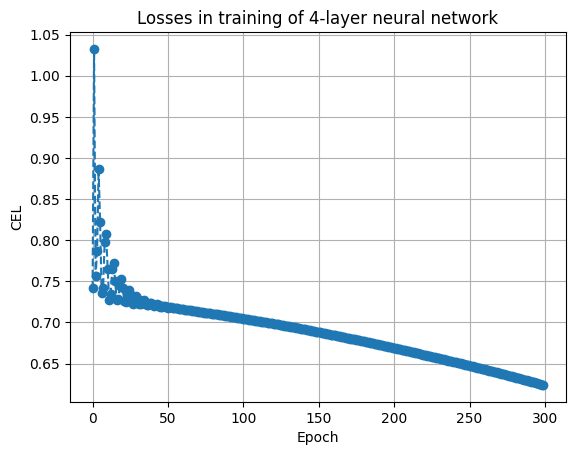

In [ ]:
plt.plot(losses, '--o')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('CEL')
plt.title('Losses in training of 4-layer neural network');
plt.show()

In [ ]:
y_pred = neural_m(X).argmax(dim=1)
accuracy_score(y, y_pred)

0.7447958366693355

In [ ]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1248
           1       0.64      0.64      0.64      1254
           2       0.63      0.56      0.59      1182
           3       0.83      0.87      0.85      1312

    accuracy                           0.74      4996
   macro avg       0.74      0.74      0.74      4996
weighted avg       0.74      0.74      0.74      4996

